In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """Messages have the type "list". The 'add_messages' function
    in the annotation defines how this state key should be updated
    (in this case, it appends messages to the list, rather than
    overwriting them)"""
    messages: Annotated[list, add_messages]

# We create a graph builder based on the state
graph_builder = StateGraph(State)

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

# Nodes represent units of work, typically regular python functions
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]} # It returns only one message, but by the state annotation "add_messages" it appends it.

# We add the node to our graph
graph_builder.add_node(
    "chatbot", chatbot
)

In [7]:
# We need to add an entry point:
graph_builder.add_edge(START, "chatbot")

# and a finish point
graph_builder.add_edge("chatbot", END)

In [8]:
# We now compile our graph
graph = graph_builder.compile()

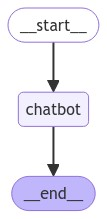

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# Test
while True:
    user_input = input("User:")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: I am an AI language model created by OpenAI, designed to assist with a wide range of questions and tasks by providing information, suggestions, and engaging in conversation. How can I help you today?
Assistant: I don't have a gender or personal identity. I'm just a program designed to assist you with information and answer your questions!
Assistant: Anthropomorphism is the attribution of human characteristics, emotions, or behaviors to non-human entities, such as animals, inanimate objects, or natural phenomena. While it can enhance storytelling, foster empathy, and aid understanding in certain contexts, there are several dangers associated with anthropomorphization:

1. **Misunderstanding Animal Behavior**: People may misinterpret animal actions or needs by projecting human emotions onto them. For example, assuming that a dog is "guilty" when it shows submissive behavior can lead to misunderstandings about its true emotional sta

# Tools

In [68]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

searcher = GoogleSerperAPIWrapper()
search = Tool(name="google_earch", func=searcher.run, description="Useful for current events.") # Must be a tool, so it has an "invoke" method.
tools = [search]

In [78]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    """Messages have the type "list". The 'add_messages' function
    in the annotation defines how this state key should be updated
    (in this case, it appends messages to the list, rather than
    overwriting them)"""
    messages: Annotated[list, add_messages]

# We create a graph builder based on the state
graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini")
# Modification: Bind tools, or, tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# Nodes represent units of work, typically regular python functions
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]} # It returns only one message, but by the state annotation "add_messages" it appends it.

# We add the node to our graph
graph_builder.add_node(
    "chatbot", chatbot
)

In [79]:
# We now need to create a function to actually run the tools if they are called.
# We do this by creatin a Node, and adding the tools to it.
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
            print(message)
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            print(tool_call)
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]["args"][0] # This is very "hardcody". How to access the args?
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [80]:
# Add it to the graph
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [81]:
# Now we need an edge. In this case, a conditional edge.
# We will implement, then, a router that checks for a tool call.
from typing import Literal


def route_tools(
    state: State
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages:= state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [82]:
# We now create the graph. This conditional routing defines the main agent loop
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # This dictionary tells the graph to interpret the conditions' outputs as
    # a specific node. It is the identity map as default.
    {"tools": "tools", "__end__": "__end__"}
)
# ANy time a tool is called, we always return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot") # Entry node
graph = graph_builder.compile() # Tool router already includes an exit.

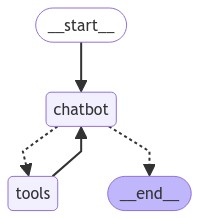

In [83]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [84]:
from langchain_core.messages import BaseMessage

user_input = "What is the probability of rain in Milan on the 28th of July?"
for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: 
content='' additional_kwargs={'tool_calls': [{'id': 'call_y71H3ZvgfG3c30ohMwUxtVjs', 'function': {'arguments': '{"args":["Milan weather forecast July 28 2023"],"config":{"tags":["weather","Milan","July 28 2023"],"max_concurrency":1}}', 'name': 'google_earch'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 103, 'total_tokens': 151}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_661538dc1f', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-ae46873b-fdb2-4d72-9f7c-e722711b86ab-0' tool_calls=[{'name': 'google_earch', 'args': {'args': ['Milan weather forecast July 28 2023'], 'config': {'tags': ['weather', 'Milan', 'July 28 2023'], 'max_concurrency': 1}}, 'id': 'call_y71H3ZvgfG3c30ohMwUxtVjs', 'type': 'tool_call'}] usage_metadata={'input_tokens': 103, 'output_tokens': 48, 'total_tokens': 151}
{'name': 'google_earch', 'args': {'args': ['Milan weather forecast July 28 2023'], 'config': {'tags': ['weather', 'Milan